#### Gaussian process regressor with Matern kernel
#### For 20 random grid cells

In [58]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
with open('/nfs/see-fs-02_users/earlacoa/emulator/dfs_gridcell_sample.pickle', 'rb') as ds:
    df_gridcells = pickle.load(ds)
    
df_gridcells.head()

,lat,lon,RES,IND,TRA,AGR,POW,PM2_5_DRY
0,30.5,114.25,0.23229,0.20507,0.299040,0.97374,0.55184,82.050903
1,30.5,114.25,1.12120,1.10980,0.870100,1.22220,1.25200,260.182960
2,30.5,114.25,0.79843,1.29460,0.090709,0.75401,0.19420,209.802636
3,30.5,114.25,0.34445,1.42240,0.751120,1.24090,1.21130,164.002287
4,30.5,114.25,0.62562,1.35890,1.058300,0.04688,0.64196,196.083809


In [72]:
df_eval = pd.DataFrame(columns=['index', 'target', 'y_test', 'y_pred', 'rmse_cv', 'r2_cv'])
df_eval_summary = pd.DataFrame(columns=['target', 'rmse_cv', 'r2_cv', 'rmse_test', 'r2_test', 'pearson_r2_test'])

lats = df_gridcells[['lat', 'lon']].drop_duplicates()['lat'].values
lons = df_gridcells[['lat', 'lon']].drop_duplicates()['lon'].values

features = ['RES', 'IND', 'TRA', 'AGR', 'POW']
target = 'PM2_5_DRY'

for gridcell in df_gridcells[['lat', 'lon']].drop_duplicates().values:
    lat, lon = gridcell
    df_gridcell = df_gridcells.loc[df_gridcells.lat == lat].loc[df_gridcells.lon == lon]
    
    X = df_gridcell[features].values
    y = df_gridcell[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=123
    )

    emulator = make_pipeline(
        Normalizer(),
        GaussianProcessRegressor(
            kernel=Matern(
                length_scale=1.0,
                nu=2.5
            ),
            n_restarts_optimizer=20,
            normalize_y=True,
            random_state=123
        )
    )

    loo = LeaveOneOut()
    #cv = loo.get_n_splits(X_train) # causes all NaNs at the moment, so using 5-fold for the time being
    cv = 5

    r2_cv = cross_val_score(emulator, X_train, y_train, cv=cv, scoring='r2')
    rmse_cv = np.sqrt(np.abs(cross_val_score(emulator, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')))

    emulator.fit(X_train, y_train)
    y_pred = emulator.predict(X_test)

    df_eval = df_eval.append([{
        'index': index, 
        'target': target,                         
        'y_test': y_test, 
        'y_pred': y_pred,          
        'rmse_cv': rmse_cv, 
        'r2_cv': r2_cv}],
        ignore_index=True,
        sort=False)

pattern = r'([+-]?\d+.?\d+)'
rmse_cv = np.mean(df_eval.loc[df_eval.target == target]['rmse_cv'].astype(str).str.extractall(pattern).astype('float').values.ravel())
r2_cv   = np.mean(df_eval.loc[df_eval.target == target]['r2_cv'].astype(str).str.extractall(pattern).astype('float').values.ravel())

y_test = df_eval.loc[df_eval.target == target]['y_test'].astype(str).str.extractall(pattern).astype('float').values.ravel()
y_pred = df_eval.loc[df_eval.target == target]['y_pred'].astype(str).str.extractall(pattern).astype('float').values.ravel()

rmse_test = np.round(np.sqrt(np.abs(mean_squared_error(y_test, y_pred))), decimals=4)
r2_test = np.round(r2_score(y_test, y_pred), decimals=4)
pearson_r2_test = pearsonr(y_test, y_pred)[0] ** 2

df_eval_summary = df_eval_summary.append([{
    'target': target,                          
    'rmse_cv': rmse_cv, 
    'r2_cv': r2_cv,                                             
    'rmse_test': rmse_test, 
    'r2_test': r2_test, 
    'pearson_r2_test': pearson_r2_test}],              
    ignore_index=True, 
    sort=False)

/nfs/a68/earlacoa/miniconda2/envs/python3/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/nfs/a68/earlacoa/miniconda2/envs/python3/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/nfs/a68/earlacoa/miniconda2/envs/python3/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_ite

In [73]:
df_eval_summary

,target,rmse_cv,r2_cv,rmse_test,r2_test,pearson_r2_test
0,PM2_5_DRY,10.604663,-22.68254,30.0885,0.6971,0.706893


In [79]:
def make_plot(index, target, df_eval, df_eval_summary, label):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    limit = np.nanmax(np.vstack(df_eval.loc[df_eval.target == target]['y_pred']))
    plt.xlim([0, limit])
    plt.ylim([0, limit])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Simulator, ' + label, fontsize=14)
    plt.ylabel('Emulator, ' + label, fontsize=14)
    plt.scatter(np.vstack(df_eval.loc[df_eval.target == target]['y_test']), np.vstack(df_eval.loc[df_eval.target == target]['y_pred']))
    x = np.arange(2 * np.ceil(limit))
    plt.plot(x, x, '', color='grey', ls='--')
    plt.plot(x, 0.5 * x, '', color='grey', ls='--')
    plt.plot(x, 2 * x, '', color='grey', ls='--')
    text = "R$^2$ CV = " + str(np.round(df_eval_summary.loc[df_eval_summary.target == target].r2_cv.values[0], decimals=3)) + \
           "\nRMSE CV = " + str(np.round(df_eval_summary.loc[df_eval_summary.target == target].rmse_cv.values[0], decimals=3)) + \
           "\nR$^2$ test = " + str(np.round(df_eval_summary.loc[df_eval_summary.target == target].r2_test.values[0], decimals=3)) + \
           "\nRMSE test = " + str(np.round(df_eval_summary.loc[df_eval_summary.target == target].rmse_test.values[0], decimals=3))
    at = matplotlib.offsetbox.AnchoredText(text, prop=dict(size=12), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

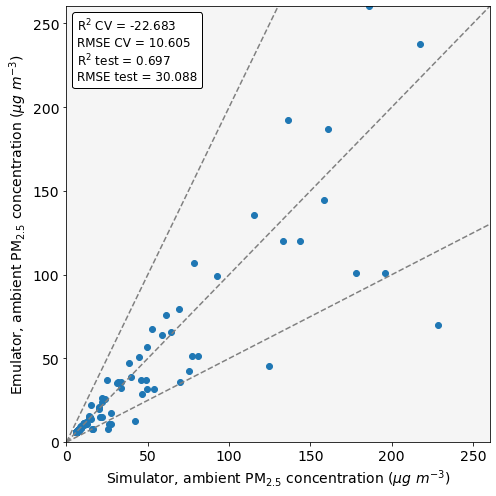

In [81]:
fig = plt.figure(1, figsize=(7, 7))
gs = gridspec.GridSpec(1, 1)

make_plot(
    0,
    target,
    df_eval,
    df_eval_summary,
    'ambient PM$_{2.5}$ concentration (${\mu}g$ $m^{-3}$)'
)

gs.tight_layout(fig, rect=[0, 0, 1.0, 1.0])
plt.show()